In [29]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.linalg import orthogonal_procrustes
from sklearn.metrics import mean_squared_error
from helpers_pmf import *
from helpers_similarity import *
from helpers_optimization import *
from scipy.optimize import minimize
import time


In [51]:
mu = 0
sigma_u = 1
sigma_v = 1
sigma = 0
lambda_reg = 0.1

d_dim = 2
#n_users = 5
#n_movies = 10 #change to n_items !!!
nb_iter = 5

## Bradley-Terry-Luce (BTL) model

Calculate the difference between each pair of elements in the 2D array X. Then, generate the probability matrix by applying the logistic function $$P(x) = \frac{e^{x}}{1 + e^{x}}$$ element-wise to the difference matrix, where x is the difference between two elements :

In [52]:
def generate_P_BT_Luce(X, n_users, alpha=1.0): # tha larger alpha, the flatter and noisier the sigmoid is !! read abt it !!
    
    diff = alpha*np.subtract.outer(X, X) 
    X_diff= np.array([diff[i, :, i, :] for i in range(n_users)])
    P = np.exp(X_diff) / (1 + np.exp(X_diff))
    
    return P, X_diff


Generate pairwise comparison data $Y_{ijk} = \pm 1$ for each user and item. The output Y is a $3D$ tensor with the shape $(n\_users, n\_items, n\_items)$. Each entry $Y[i,j,k]$ corresponds to whether user i prefers item j over item k. For example, line 0 of Y corresponds to the pairwise comparisons of user 0 with all items: $Y[0,0,:]$ represents whether user 0 prefers item 0 over all other items $(item\_0, item\_1, item\_2, etc..)$, and so on.

In [53]:
def pairwise_comparisons(P):
    
    Y = np.random.binomial(n=1, p=P, size=P.shape) 
    Y = np.where(Y == 0, -1, Y)
    
    return Y

In [54]:
def hinge_loss(x):
    
    return np.maximum(0, 1 - x)**2 

In [55]:
def sum_loss(U, V, Y):
    n, m, _ = Y.shape
    loss = 0
    for i in range(n):
        for j in range(m):
            for k in range(j):
                if Y[i, j, k] != 0:
                    v = V[:,j] - V[:,k]
                    x = np.dot(U[:,i], v)
                    loss += hinge_loss(Y[i, j, k] * x)
    return loss

In [56]:
def loss_U(U, Y, V, lambda_reg, d_dim, n_users):
    
    U=U.reshape((d_dim, n_users))
    loss = sum_loss(U, V, Y)
    reg = lambda_reg * np.linalg.norm(U, 'fro') ** 2 
    
    return loss + reg

In [57]:
def loss_V(V, Y, U, lambda_reg, d_dim, n_movies):
    
    V = V.reshape((d_dim, n_movies))
    loss = sum_loss(U, V, Y)
    reg = lambda_reg * np.linalg.norm(V, 'fro') ** 2
    
    return loss + reg

In [58]:
def optimization_U_V(d_dim, n_users, n_movies):
    start = time.time()

    U, V, X = generate_U_V_R(mu, sigma_u, sigma_v, sigma, d_dim, n_users, n_movies)
    P, _ = generate_P_BT_Luce(X, n_users)
    Y = pairwise_comparisons(P)

    #initialize U and V with random values
    U0 = np.random.normal(mu, sigma_u, d_dim*n_users)
    V0 = np.random.normal(mu, sigma_u, d_dim*n_movies)
    print("Preprocessing time: ", time.time() - start)
    
    start = time.time()
    #for V fixed, find the optimal value for U, and vice versa 
    U_res = minimize(loss_U, U0, args=(Y, V, lambda_reg, d_dim, n_users), method='L-BFGS-B') #method='L-BFGS-B' ? # compare runtime
    print("U optimization time: ", time.time() - start)

    start = time.time()
    V_res = minimize(loss_V, V0, args=(Y, U, lambda_reg, d_dim, n_movies), method='L-BFGS-B') 
    print("V optimization time: ", time.time() - start)
    
    U_result = 0
    if U_res.success :
        U_result = U_res.x.reshape((d_dim, n_users))
    else :
        print('Minimization failure for U')
        print(U_res.message)
        U_result = U_res.x.reshape((d_dim, n_users))
    diff_norm_U = np.linalg.norm(U - U_result, 'fro')/np.sqrt(n_users) 
    
    V_result = 0
    if V_res.success :
        V_result = V_res.x.reshape((d_dim, n_movies))
    else :
        print('Minimization failure for V')
        print(V_res.message)
        V_result = V_res.x.reshape((d_dim, n_movies))
    diff_norm_V = np.linalg.norm(V - V_result, 'fro')/np.sqrt(n_movies) 
    
    return diff_norm_U, diff_norm_V



In [61]:
def optimization_U_V(d_dim, n_users, n_movies, preproc_times, U_times, V_times):
    
    start = time.perf_counter()
    U, V, X = generate_U_V_R(mu, sigma_u, sigma_v, sigma, d_dim, n_users, n_movies)
    P, _ = generate_P_BT_Luce(X, n_users)
    Y = pairwise_comparisons(P)
    U0 = np.random.normal(mu, sigma_u, d_dim*n_users)
    V0 = np.random.normal(mu, sigma_u, d_dim*n_movies)
    preproc_times.append(time.perf_counter() - start)
    
    start = time.perf_counter()
    U_res = minimize(loss_U, U0, args=(Y, V, lambda_reg, d_dim, n_users))#, method='L-BFGS-B'
    U_times.append(time.perf_counter() - start)

    start = time.perf_counter()
    V_res = minimize(loss_V, V0, args=(Y, U, lambda_reg, d_dim, n_movies))#, method='L-BFGS-B'
    V_times.append(time.perf_counter() - start)

    U_result = 0
    if U_res.success :
        U_result = U_res.x.reshape((d_dim, n_users))
    else :
        print('Minimization failure for U')
        print(U_res.message)
        U_result = U_res.x.reshape((d_dim, n_users))
    diff_norm_U = np.linalg.norm(U - U_result, 'fro')/np.sqrt(n_users) 
    
    V_result = 0
    if V_res.success :
        V_result = V_res.x.reshape((d_dim, n_movies))
    else :
        print('Minimization failure for V')
        print(V_res.message)
        V_result = V_res.x.reshape((d_dim, n_movies))
    diff_norm_V = np.linalg.norm(V - V_result, 'fro')/np.sqrt(n_movies) 
    
    return diff_norm_U, diff_norm_V


In [62]:
def norm_results(d_dim, n_users, n_movies, preproc_times, U_times, V_times):
    avg_U = 0
    avg_V = 0
    n_U = 0
    n_V = 0
    for i in range(nb_iter):
        diff_U, diff_V = optimization_U_V(d_dim, n_users, n_movies, preproc_times, U_times, V_times)
        if diff_U is not np.nan:
            avg_U += diff_U
            n_U += 1
        if diff_V is not np.nan:
            avg_V += diff_V
            n_V += 1
    print(avg_U, n_U)
    print(avg_V, n_V)
    avg_U /= n_U
    avg_V /= n_V
    return avg_U, avg_V

In [70]:
N_vals = [5, 10, 20]#, 30, 40, 50]
M_vals = [5, 10, 20]#, 30, 40, 50]
preproc_times = []
U_times = []
V_times = []
data = []
for i in range(len(N_vals)):
    for j in range(len(M_vals)):
        print(i,j)
        avg_U, avg_V = norm_results(d_dim, N_vals[i], M_vals[j], preproc_times, U_times, V_times)
        row= [N_vals[i], M_vals[j], avg_U, avg_V]
        data.append(row)

0 0
3.935080049629944 5
5.220718050761191 5
0 1
3.6522300504748593 5
4.5483339788066 5
0 2
4.350897126242701 5
4.871468359026252 5
1 0
5.334664070971472 5
4.319621141788892 5
1 1
4.660557278085857 5
4.623909095179203 5
1 2
3.9931500465518672 5
4.0189792235999935 5
2 0
5.493584072689603 5
5.448045240690984 5
2 1
4.852817471870804 5
4.890013876352797 5
2 2
4.738340363565905 5
4.118997817502356 5


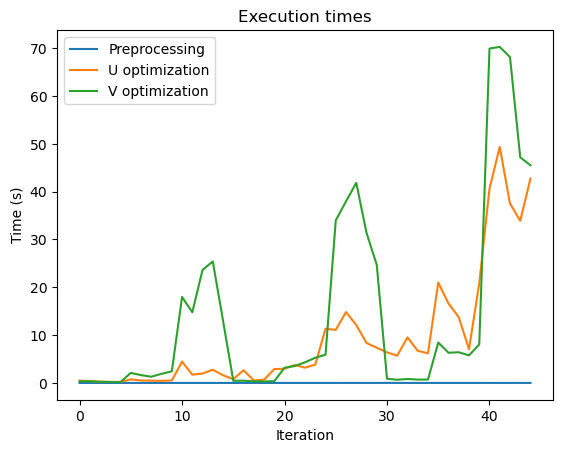

In [71]:
plt.plot( preproc_times, label='Preprocessing')
plt.plot( U_times, label='U optimization')
plt.plot( V_times, label='V optimization')
plt.xlabel('Iteration')
plt.ylabel('Time (s)')
plt.title('Execution times')
plt.legend()
plt.show()

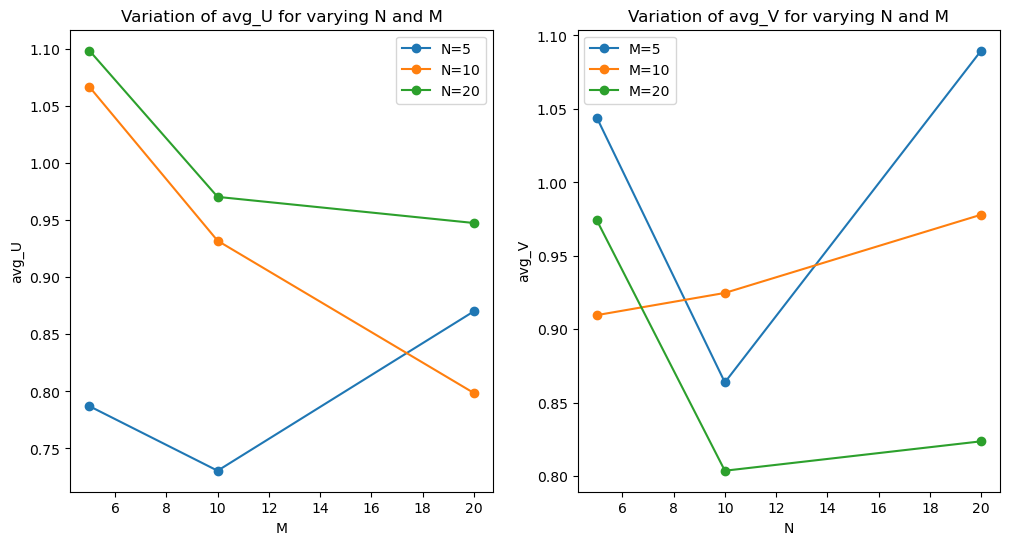

In [72]:
df = pd.DataFrame(data, columns = ['N', 'M', 'avg_U', 'avg_V'])
#df.to_csv('results_optimization.csv')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
# plot as a function of M for avg_U and as a function of N fro avg_V
for n in df['N'].unique():
    df_m = df[df['N'] == n]
    ax1.plot(df_m['M'], df_m['avg_U'], marker='o', label=f'N={n}')
for m in df['M'].unique():
    df_n = df[df['M'] == m]
    ax2.plot(df_n['N'], df_n['avg_V'], marker='o', label=f'M={m}')

ax1.set_xlabel('M')
ax1.set_ylabel('avg_U')
ax1.set_title('Variation of avg_U for varying N and M')
ax1.legend()

ax2.set_xlabel('N')
ax2.set_ylabel('avg_V')
ax2.set_title('Variation of avg_V for varying N and M')
ax2.legend()

plt.show()